***Date: 27/02/17***  
***Title: Failure of original C++ code and the introduction of the multi-channel Platen method.***

In [43]:
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import csv
import os

%matplotlib inline
pylab.rcParams['figure.figsize'] = (12, 8)

def mean_photons_calc(probabilities):
    photons = np.zeros(probabilities.shape[1])
    for i in range(photons.shape[0]):
        for j in range(probabilities.shape[0]):
            photons[i] = photons[i] + j * probabilities[j, i]
    return photons

def times_qload(folder_path):
    times_path = folder_path + '/times'
    times = qload(times_path)
    times = times / (2 * np.pi * 1000)
    return times

def photon_probabilities_qload(folder_path):
    expectations_path = folder_path + '/expectations'
    expectations = qload(expectations_path)
    probabilities = np.array([expectations[x] for x in range(0, len(expectations))]);
    return probabilities

def qutip_vs_cpp(q_folder, cpp_folder, title='Give me a title.', legend=['line1', 'line2']):
    row_idx = 0
    cwd = os.getcwd()
    with open(cwd + cpp_folder + '/photons9.dat' , 'rb') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            if row_idx == 0:
                snapshots = len(row) - 1
                mean_photons = np.zeros(snapshots)
            photons = row[0:snapshots]
            photons = [float(value) for value in photons]
            photons = np.array(photons)
            mean_photons += photons
            row_idx += 1
    mean_photons = mean_photons / row_idx

    folder_path = cwd + q_folder
    times = times_qload(folder_path)
    probabilities = photon_probabilities_qload(folder_path)
    final_probabilities = probabilities[:, probabilities.shape[1] - 1]
    master_photons = mean_photons_calc(probabilities)

    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    plt.plot(times[0:times.size - 1], mean_photons)
    plt.plot(times, master_photons)
    plt.legend(legend)
    plt.xlabel(r'Time / $\mu$s', fontsize=16)
    plt.ylabel('Photons', fontsize=16)
    plt.title(title, fontsize=16)
    plt.tick_params(axis='both', labelsize=18) 

Loaded ndarray object.
Loaded list object.


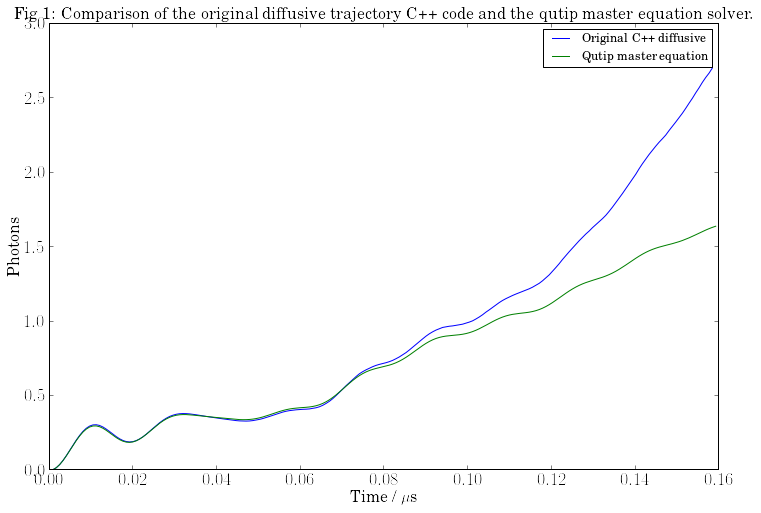

In [54]:
q_file = '/master_standard/2017-02-24--14-56-01'
cpp_file = '/diffusive_failure/2017.02.22--19-57-30'
title = 'Fig 1: Comparison of the original diffusive trajectory C++ code and the qutip master equation solver.'
legend = ['Original C++ diffusive','Qutip master equation']
qutip_vs_cpp(q_file, cpp_file, title=title, legend=legend)

Fig 1: The graph above demonstrates disagreement between the qutip master equation solver and the diffusive C++ code we have been using to simulate the transmon-cavity system.  
  
The parameters of the system are as follows:
$\kappa = 1$ MHz  
$\gamma = 1$ MHz  
$g = 309.6$ MHz  
$\epsilon = 4$ MHz  
$\omega_c = 10.4267$ GHz  
$\omega_q = 9.39128$ GHz  
$\omega_d = 10.5066$ GHz  
$\delta = \omega_q - \omega_c = -1.03542$ GHz  
$\chi = -97$ MHz  
with the transmon and the cavity starting in their ground states. These parameters are stored in the following file:

In [52]:
cat ./diffusive_failure/2017.02.22--19-57-30/settings.cfg

folder=proof_of_failure
endtime=1.0000000000e+03
transmon_levels=5
cavity_levels=20
snap_to_snap=250
bins=50000
snapshots_number=200
kappa=1.0000000000e-03
gamma_c=1.0000000000e-03
g=3.0960000000e-01
epsilon=4.0000000000e-03
omega_c=1.0426700000e+01
omega_q=9.3912800000e+00
omega_d=1.0506600000e+01
theta=3.1415926540e+00
phi=0.0000000000e+00
samplesize=10000
photon_number=0
chi=-9.7000000000e-02


Themis disagrees with me but it is my opinion that the discrepancy between the methods demonstrated above is due to a mistake in the implementation of the Platen method described in section 7.2.5 of Breuer and Petruccione (page 372). Equation 7.47 described the stochastic evolution of the wavefunction with a single noise channel. To include multiple noise channels we will need a Wiener increment for each channel. The multi-channel Platen method is described in section 15.1 on page 486 of Kloden and Platen (Numerical solution of stochastic differenteial equations, 1992).

Loaded ndarray object.
Loaded list object.


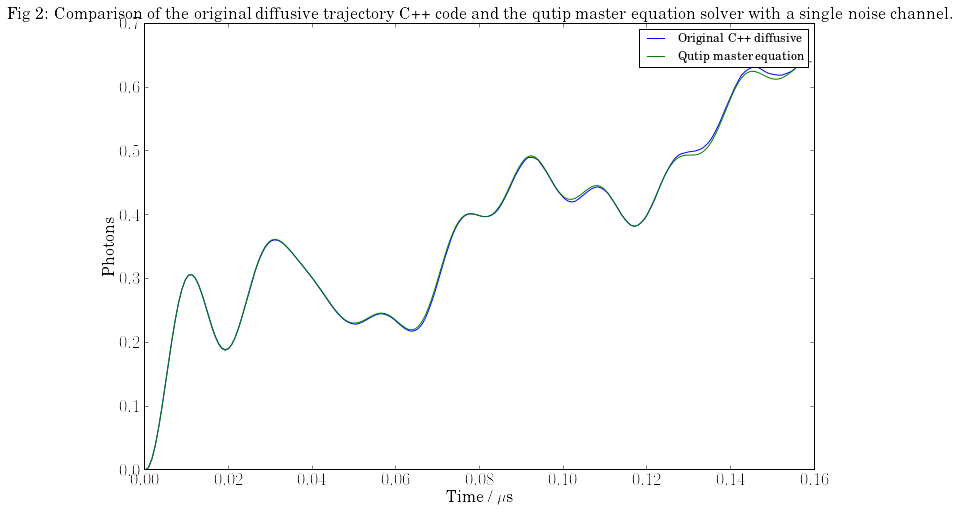

In [55]:
q_file = '/master_standard_one_decoherence/2017-02-27--15-38-43'
cpp_file = '/diffusive_failure/2017.02.22--20-27-12'
title = 'Fig 2: Comparison of the original diffusive trajectory C++ code and the qutip master equation solver with a single noise channel.'
legend = ['Original C++ diffusive','Qutip master equation']
qutip_vs_cpp(q_file, cpp_file, title=title, legend=legend)

Fig 2: If my hypothesis is correct then we would expect the original method to agree with the master equation approach when one of the noise channels is turned off. This is what I have done above. I have repeated the simulations used to produce Fig 1 but now with $\gamma = 0$. The two methods are seen to agree.

Loaded ndarray object.
Loaded list object.


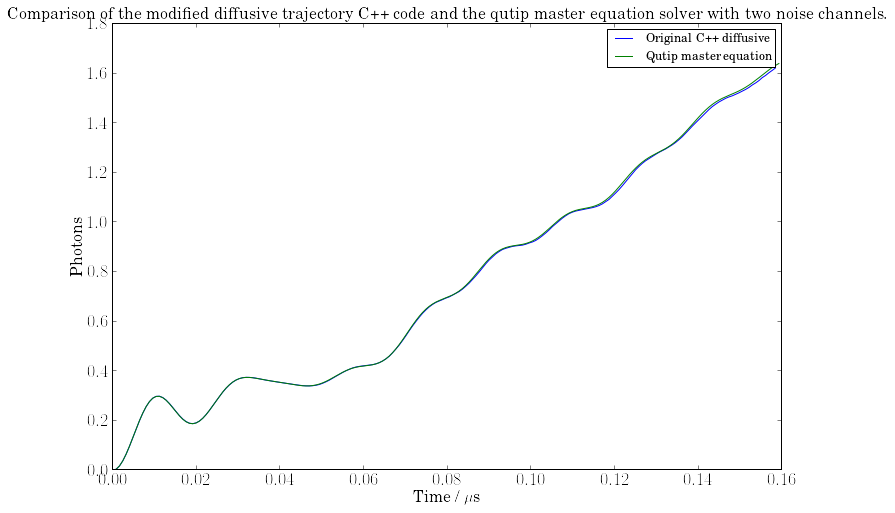

In [50]:
q_file = '/master_standard/2017-02-24--14-56-01'
cpp_file = '/multi_noise_verification/2017.02.23--10-33-12'
title = 'Comparison of the modified diffusive trajectory C++ code and the qutip master equation solver with two noise channels.'
legend = ['Modified C++ diffusive','Qutip master equation']
qutip_vs_cpp(q_file, cpp_file, title=title, legend=legend)

Fig 3: In order to simulate multiple noise channels correctly I have rewritten the C++ code to use the general method described in Kloeden and Platen. Using this code I repeat the simulation with $\kappa = \gamma = 1$ MHz.  
  
  Whatever method we use to simulate the transmon-cavity system it should agree with the results of the qutip master equation solver. Since the modified C++ code shows much closer agreement with qutip I intend to switch solely to using it for future simulations.